In [1]:
import sys
sys.path.append("C:\\Users\josep\Documents\Anaconda\pkgs")
import help_tools
import wave_tools
import cv2
import h5py
from matplotlib import cm
import radar_tools
import numpy as np
from wave_tools import ConstructWave, surface_core, peak_tracking
from wave_tools import fft_interpolate, fft_interface, Spectrum
from wave_tools import SpectralAnalysis
import matplotlib.pyplot as plt
from help_tools import plotting_interface
from wave_tools import surface_core, fft_interface, dispersionRelation
from help_tools import plotting_interface, polar_coordinates, convolutional_filters, moving_average
from scipy.optimize import least_squares
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
from scipy.fftpack import fftn, fftshift
from scipy.stats import t

In [2]:
%matplotlib widget
# makes plots interactive

In [204]:
%matplotlib inline

In [4]:
sys.path.append("C:\\Users\josep\Desktop\PHYC40900_Project TP\Data_NEW")
fileName ='shearing_curr_res_7.5_dt_1.0_T_1200_U_1.0exp(0.5z)+0.05_psi_0_smax_30_0_surf3d.hdf5'
# file with psi = 0 
f = h5py.File('C:\\Users\josep\Desktop\PHYC40900_Project TP\Data_NEW\shearing_curr_res_7.5_dt_1.0_T_1200_U_1.0exp(0.5z)+0.05_psi_0_smax_30_0_surf3d.hdf5', 'r')

# file with psi = 30
# f = h5py.File('C:\\Users\josep\Desktop\PHYC40900_Project TP\Data_NEW\shearing_curr_res_7.5_dt_1.0_T_1200_U_1.0exp(0.5z)+0.05_psi_30_smax_70_0_surf3d.hdf5', 'r')

In [5]:
x = f.get('x')
y = f.get('y')
z = f.get('z')
t = f.get('t')
k = f.get('k')
U = f.get('U')
Uk = f.get('Uk')
eta = f.get('eta')
x = np.array(x)
y = np.array(y)
z = np.array(z)
t = np.array(t)
k = np.array(k)
U = np.array(U)
Uk = np.array(Uk)
eta = np.array(eta)

In [6]:
# with psi = 0
surf3d = surface_core.surface_from_file("C:\\Users\josep\Desktop\PHYC40900_Project TP\Data_NEW\shearing_curr_res_7.5_dt_1.0_T_1200_U_1.0exp(0.5z)+0.05_psi_0_smax_30_0_surf3d.hdf5")

# with psi = 30
# surf3d = surface_core.surface_from_file("C:\\Users\josep\Desktop\PHYC40900_Project TP\Data_NEW\shearing_curr_res_7.5_dt_1.0_T_1200_U_1.0exp(0.5z)+0.05_psi_30_smax_70_0_surf3d.hdf5")
spec3d = surf3d.define_SpectralAnalysis()

In [7]:
eta = f.get('eta')
eta = np.array(eta)

In [8]:
eta_flipped = np.transpose( np.flip(eta, axis= 2) , (1, 2, 0))
eta_flipped.shape

(67, 67, 1200)

In [9]:
eta = eta_flipped
eta.shape

(67, 67, 1200)

In [10]:
# new version with eta changed dimension 
def cylinder_cross_section(Spectrum, dtheta, power_Spectrum_cut , order=None):
    if order is None:
        order = 4

    Kx_2D = np.squeeze(Kx_3D[:,:,0])
    Ky_2D = np.squeeze(Ky_3D[:,:,0])
    W_1D = np.squeeze(W_3D[0,0,:])

    theta_2D = np.arctan2(-Ky_2D, -Kx_2D)
    theta_3D = np.tile(theta_2D[:, :, np.newaxis], (1, 1, W_1D.size))

    theta_vals = np.arange(-np.pi, np.pi, dtheta)
    S_cyl = np.zeros((W_1D.size, theta_vals.size))

    for ii in range(theta_vals.size):
        theta_diff = np.angle(np.exp(1j * theta_3D) * np.exp(-1j * theta_vals[ii]))
        theta_filt = np.exp(-2 * (theta_diff / dtheta) ** order)
        S_filt = power_Spectrum_cut * theta_filt
        S_cyl[:, ii] = np.nansum(S_filt, axis=(0, 1))

    thetaM, omegaM = np.meshgrid(theta_vals, W_1D)

    Scyl = {
        'P_k': S_cyl,
        'thetaM': thetaM,
        'omegaM': omegaM,
        'Kx_2D': Kx_2D, 
        'Ky_2D': Ky_2D,
        'W_1D': W_1D,
        'theta_2D':theta_2D,
        'theta_3D':theta_3D,
        'theta_vals':theta_vals,
        'theta_diff':theta_diff,
        'theta_filt':theta_filt
    }

    return Scyl

In [11]:
dx = 7.5

In [12]:
dk = 2*np.pi/(dx*min(eta.shape[0], eta.shape[1]))
dk

0.012503851357571316

In [13]:
frequencyLimits = [0.01,20.0]
# frequency limits for masking the spectrum [min max], rad/sec

In [14]:
Kx = spec3d.kx
Ky = spec3d.ky
w = spec3d.w

In [15]:
dKx = Kx[1] - Kx[0]
dKy = Ky[1] - Ky[0]
dW = w[1] - w[0]

In [16]:
Norm = dKx * dKy * dW

In [17]:
# Get power spectra
Spectrum_raw = fftshift(fftn(eta) / np.prod(eta.shape))
power_Spectrum = np.abs(Spectrum_raw / Norm)**2

In [18]:
power_Spectrum

array([[[0.0003803 , 0.00038039, 0.00037981, ..., 0.00038023,
         0.00038076, 0.00038051],
        [0.00038624, 0.00038567, 0.00038531, ..., 0.00038688,
         0.00038656, 0.00038527],
        [0.00039817, 0.00039769, 0.0003965 , ..., 0.00040039,
         0.00039836, 0.00039819],
        ...,
        [0.00039611, 0.00039523, 0.00039554, ..., 0.00039549,
         0.00039607, 0.00039608],
        [0.00038371, 0.00038475, 0.00038526, ..., 0.00038214,
         0.00038406, 0.00038371],
        [0.00037908, 0.00037975, 0.00037982, ..., 0.00038066,
         0.00037899, 0.00038024]],

       [[0.00039662, 0.00039677, 0.00039688, ..., 0.00039758,
         0.00039772, 0.00039724],
        [0.0004035 , 0.00040388, 0.00040219, ..., 0.00040498,
         0.0004043 , 0.00040389],
        [0.00041642, 0.00041672, 0.00041568, ..., 0.00041939,
         0.00041783, 0.00041654],
        ...,
        [0.00041015, 0.00041087, 0.00041003, ..., 0.00041099,
         0.00041064, 0.00041129],
        [0.0

# Try according to "An Algorithm for Surface Current Retrieval from X-band Marine Radar Images" Paper


In [19]:
power_Spectrum.shape

(67, 67, 1200)

# 2.1 Smooth Tapering Function

In [20]:
import numpy as np

def tapering_function(n, a, L):
    if 0 <= n <= a * L / 2:
        return 0.5 * (1 + np.cos(np.pi * (2 * n / (a * L) - 1)))
    elif a * L / 2 <= n <= L * (1 - a / 2):
        return 1
    elif L * (1 - a / 2) <= n <= L:
        return 0.5 * (1 + np.cos(np.pi * (2 * n / (a * L) - 2 / a + 1)))
    else:
        return 0.0

def apply_tapering_3d(data, a):
    shape = data.shape
    tapering_3d = np.ones(shape)

    for i in range(shape[0]):
        for j in range(shape[1]):
            for k in range(shape[2]):
                tapering_3d[i, j, k] = tapering_function(i, a, shape[0]) * tapering_function(j, a, shape[1]) * tapering_function(k, a, shape[2])

    tapered_data = data * tapering_3d

    return tapered_data

In [21]:
a_value = 0.1

In [22]:
eta.shape

(67, 67, 1200)

In [23]:
tapered_eta = apply_tapering_3d(eta, a_value)

In [24]:
tapered_eta.shape

(67, 67, 1200)

In [25]:
eta.shape

(67, 67, 1200)

In [26]:
np.max(eta - tapered_eta)

1.8783780336380005

In [27]:
tapered_eta.shape

(67, 67, 1200)

In [28]:
tapered_padded_eta = np.pad(tapered_eta, ((30,31), (30,31), (0, 0)), 'constant',  constant_values=0)

In [29]:
tapered_padded_eta.shape

(128, 128, 1200)

In [30]:
dKx = Kx[1] - Kx[0]
dKy = Ky[1] - Ky[0]
dW = w[1] - w[0]
Norm = dKx * dKy * dW

In [31]:
dx = 7.5 
dy = 7.5
dt = 1

In [32]:
# Taper Applied
Nx, Ny, Nt = tapered_padded_eta.shape
Kx = (2 * np.pi * 1 / dx / Nx) * np.arange(-np.ceil((Nx - 1) / 2), np.floor((Nx - 1) / 2) + 1) # 67 values
Ky = (2 * np.pi * 1 / dy / Ny) * np.arange(-np.ceil((Ny - 1) / 2), np.floor((Ny - 1) / 2) + 1) # 67 Values
w = (2 * np.pi * 1 / dt / Nt) * np.arange(-np.ceil((Nt - 1) / 2), np.floor((Nt - 1) / 2) + 1) # 1200 Values

In [33]:
# Taper Applied

# Get power spectra
Spectrum_raw = fftshift(fftn(tapered_padded_eta) / np.prod(tapered_padded_eta.shape))
power_Spectrum = np.abs(Spectrum_raw / Norm)**2

In [124]:
Nx, Ny, Nt = eta.shape
Kx = (2 * np.pi * 1 / dx / Nx) * np.arange(-np.ceil((Nx - 1) / 2), np.floor((Nx - 1) / 2) + 1) # 67 values
Ky = (2 * np.pi * 1 / dy / Ny) * np.arange(-np.ceil((Ny - 1) / 2), np.floor((Ny - 1) / 2) + 1) # 67 Values
w = (2 * np.pi * 1 / dt / Nt) * np.arange(-np.ceil((Nt - 1) / 2), np.floor((Nt - 1) / 2) + 1) # 1200 Values

In [125]:
# Get power spectra
Spectrum_raw = fftshift(fftn(eta) / np.prod(eta.shape))
power_Spectrum = np.abs(Spectrum_raw / Norm)**2

# 2.2 Extracting the Dispersion Shell

## High Pass Filter

In [126]:
I_0 = power_Spectrum
I_0.shape

(67, 67, 1200)

In [127]:
w_cut = 0.03 * 2*np.pi

In [128]:
dx = 7.5 
dy = 7.5
dt = 1

In [129]:
# Create a boolean mask based on the condition w >= w_cut
mask = (w >= w_cut)

In [130]:
I_1 = np.where(mask[ None, None,:], I_0, 0)

## Energy Threshold Filter

In [131]:
# Create a boolean mask based on the condition energy

P = np.max(I_1) / 2000
# Threshold

condition = ( np.max(I_1, axis=2) >= P )
# Is  maximum energy for each column vector along the ω axis > P

In [132]:
I_2 = np.where(condition[:, :, None], I_1, 0)

In [133]:
I_2.shape

(67, 67, 1200)

## Peak Identification

In [134]:
from scipy.signal import find_peaks, peak_widths, peak_prominences

In [135]:
def check_prominent_peaks(kx, ky):
    y = I_2[kx, ky,:]
    
    wj = np.zeros((I_2.shape[0], I_2.shape[1]))
    
    if np.max(y) < 1:
        wj[kx, ky] = 0
    # If Power Spectrum is 0 then wj is 0
        
    else:
        peak_heights = y
        
        # Find the peak with the maximum height
        max_peak_index = np.argmax(peak_heights)
        max_peak_height = peak_heights[max_peak_index]

        threshold = 6

        # Check if the maximum peak 6 times larger than the others
        # If it is we conclude it is a peak on its own and print
        if max_peak_height > threshold * np.max(peak_heights[peak_heights != max_peak_height]):
            wj[kx,ky] = w[max_peak_index]
            
        else:
            pass
            
    return wj

In [136]:
def identification(kx, ky, ratio=10., prominence=1e5, distance=5):
    
    '''Scans for peaks and then sorts them by heights. 
    It keeps the peaks which are ratio times smaller than the next'''
    
    y = I_2[kx,ky,:]
    wj = np.zeros((I_2.shape[0], I_2.shape[1]))
    
    if np.max(y) < 1:
        wj[kx, ky] = 0
    # If Power Spectrum is 0 then wj is 0
    
    else:
        peaks, stats = find_peaks(y, prominence=prominence, distance=distance)
        order = np.flip(np.argsort(stats["prominences"]))

        values = []

        if len(peaks) == 1:
            values.append(w[peaks[0]])
            wj[kx,ky] = w[peaks[0]]

        elif len(peaks) > 1:
            for i, j in zip(order[:-1], order[1:]):
                if stats["prominences"][i] >= ratio * stats["prominences"][j]:
                    values.append(w[peaks[i]])
                    wj[kx,ky] = w[peaks[i]]
                    
#        return {
#            "values": values,
#            "order": order,
#            "peaks": peaks,
#            "stats": stats,
#        }
    
    return wj 
    # rteurns 2d array wj 
    # it will al be 0 if there are no prominent peaks 
    # Otherwise it will have the w value of the singular prominent peak and the ret will be 0 

Text(0.5, 1.0, 'Should be counted')

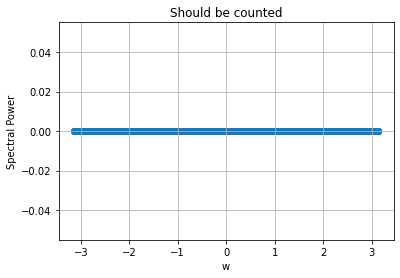

In [205]:
plt.scatter(w, I_2[40,43,:])

plt.xlabel("w")
plt.ylabel("Spectral Power")
plt.grid(True)
plt.title("Should be counted")

In [46]:
wj = identification(40, 53, ratio=10., prominence=1e5, distance=25)

In [47]:
np.min(wj)

0.0

Text(0.5, 1.0, 'Should be counted')

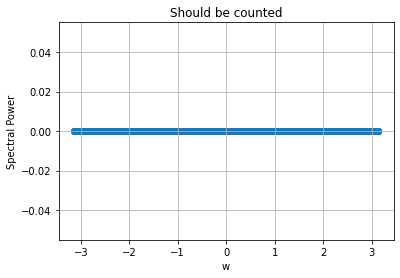

In [48]:
plt.scatter(w, I_2[14,53,:])

plt.xlabel("w")
plt.ylabel("Spectral Power")
plt.grid(True)

plt.title("Should be counted")

In [49]:
wj = identification(14, 53, ratio=10., prominence=1e5, distance=25)

In [50]:
np.min(wj)

0.0

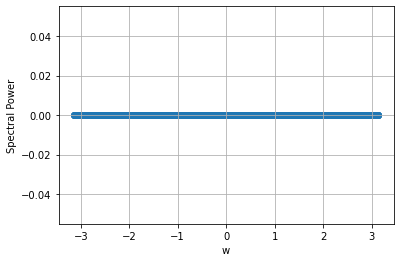

In [51]:
plt.scatter(w, I_2[22,53,:])

plt.xlabel("w")
plt.ylabel("Spectral Power")
plt.grid(True)

In [52]:
wj = identification(22, 53, ratio=10., prominence=1e5, distance=25)

In [53]:
np.min(wj)

0.0

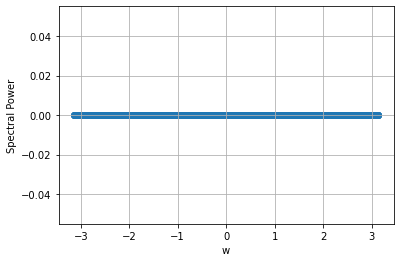

In [54]:
plt.scatter(w, I_2[10,53,:])

plt.xlabel("w")
plt.ylabel("Spectral Power")
plt.grid(True)

In [55]:
wj = identification(10, 53, ratio=10., prominence=1e5, distance=25)

In [56]:
np.max(wj)

0.0

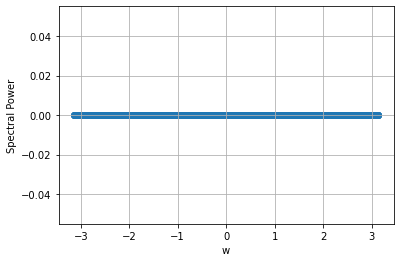

In [57]:
y = I_2[32,11,:]

plt.scatter(w, y)

plt.xlabel("w")
plt.ylabel("Spectral Power")
plt.grid(True)

In [58]:
wj = identification(32, 11, ratio=10., prominence=1e5, distance=25)

In [59]:
np.max(wj)

0.0

In [138]:
wj_array = []

for kx in range(I_2.shape[0]):
    for ky in range(I_2.shape[1]):
        wj_array.append(identification(kx, ky, ratio=10., prominence=1e5, distance=15))

In [139]:
wj_array

[array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 arr

In [140]:
w0_2D = np.sum(wj_array, axis=0)
# gives the 2d array w0(kx,ky)

In [141]:
w0_2D.shape

(67, 67)

In [142]:
w0_2D.shape

(67, 67)

In [143]:
w0_2D.shape

(67, 67)

In [144]:
w0 = w0_2D[w0_2D != 0]

In [145]:
w0_2D.shape

(67, 67)

In [146]:
nonzero_indices = np.nonzero(w0_2D)

In [147]:
nonzero_indices[0].shape

(627,)

In [148]:
kx_indices = nonzero_indices[0]
ky_indices = nonzero_indices[1]

In [149]:
kx_trip = Kx[kx_indices]
ky_trip = Ky[ky_indices]

In [167]:
def plot_disp_shell(axes, h, z, U, psi, label='', plot_type='surf', linestyles='line', put_clabel=True):
    g = 9.81
    alpha = 0.5 # value that defines opacity in plot
    dk = 0.005
    k = np.arange(0.01, 0.35, dk)
    dtheta=0.05
    theta=np.arange(0, 2*np.pi+dtheta, dtheta)
    kk, th = np.meshgrid(k, theta, indexing='ij')
    U_eff = 2*kk*np.sum(U*np.exp(np.outer(2*kk,z)), axis=1).reshape(kk.shape)*np.abs(z[1]-z[0])
    ww = kk*U_eff*np.cos(theta-psi) + np.sqrt(kk*g*np.tanh(kk*h))
    kx = kk*np.cos(th)
    ky = kk*np.sin(th)
    if plot_type=='surf':
        axes.plot_surface(kx, ky, ww, alpha=alpha, label=label)
        axes.set_xlabel(r'$k_x~[\mathrm{rad~m}^{-1}]$')
        axes.set_ylabel(r'$k_y~[\mathrm{rad~m}^{-1}]$')
        axes.set_zlabel(r'$\omega~[\mathrm{rad~s}^{-1}]$')
    elif plot_type=='contour':
        levels = [0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8]
        c = plt.contour(kx, ky, ww, levels=levels, linestyles=linestyles)#, label=label)
        if put_clabel:
            plt.clabel(c)
        plt.xlabel(r'$k_x~[\mathrm{rad~m}^{-1}]$') 
        plt.ylabel(r'$k_y~[\mathrm{rad~m}^{-1}]$')
        plt.axis('equal')
        
    return kx, ky, ww, kk, th

In [168]:
%matplotlib widget

In [175]:
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

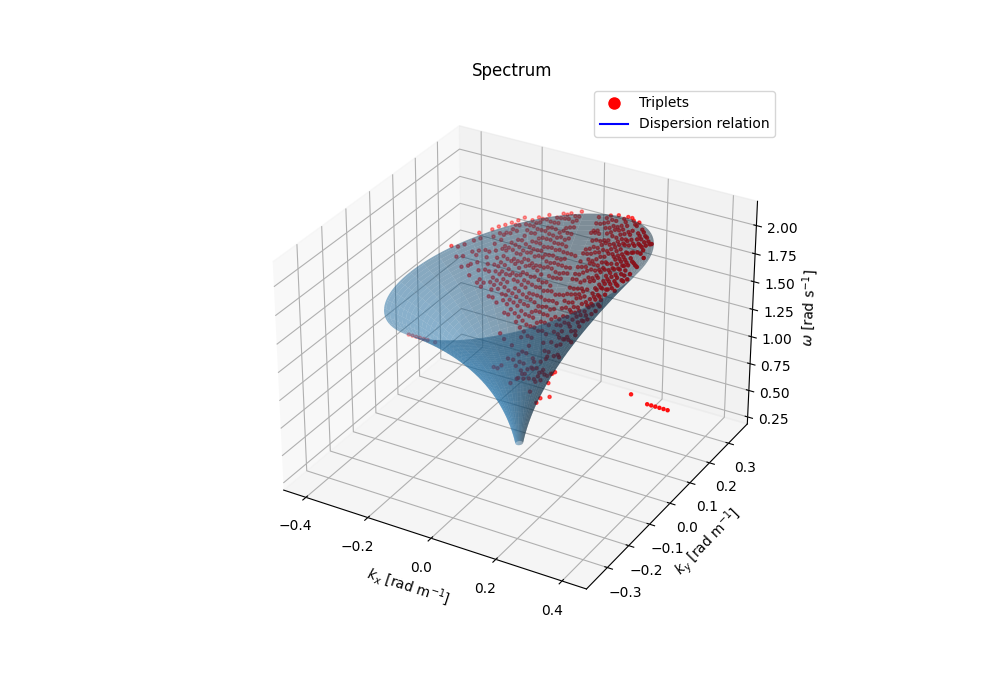

In [180]:
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(-kx_trip, -ky_trip, w0, color = "red", s = 5)
plt.title("Spectrum")

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('η(x,y)')

kx, ky, ww, kk, th = plot_disp_shell(ax, h=1000, z=z, U=U, psi=0)

# Create legend manually with a dot for 'Triplets'
legend_elements = [
    mlines.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Triplets'),
    mlines.Line2D([0], [0], color='blue', label='Dispersion relation')
]

# Create legend
ax.legend(handles=legend_elements)
 
# show plot
plt.show()

In [75]:
# We now have a rough estimation of the dispersion shell using the power spectrum

# 2.3 Converting to the Polar Current Shell

In [76]:
from scipy.stats import t

In [77]:
%matplotlib inline

In [78]:
# use Kx Ky and w0

In [177]:
w0_2D.shape

(67, 67)

In [178]:
Kx.shape

(67,)

In [179]:
Ky.shape

(67,)

In [198]:
# kx_2D, ky_2D= np.meshgrid(kx_trip, ky_trip, indexing='ij')
kx_2D, ky_2D= np.meshgrid(Kx, Ky, indexing='ij')

In [199]:
K_2D = np.sqrt(kx_2D**2 + ky_2D**2)
theta_2D = np.arctan2(ky_2D, kx_2D)

In [200]:
K_2D

array([[0.58354283, 0.57476928, 0.56613595, ..., 0.56613595, 0.57476928,
        0.58354283],
       [0.57476928, 0.56585972, 0.55708833, ..., 0.55708833, 0.56585972,
        0.57476928],
       [0.56613595, 0.55708833, 0.5481766 , ..., 0.5481766 , 0.55708833,
        0.56613595],
       ...,
       [0.56613595, 0.55708833, 0.5481766 , ..., 0.5481766 , 0.55708833,
        0.56613595],
       [0.57476928, 0.56585972, 0.55708833, ..., 0.55708833, 0.56585972,
        0.57476928],
       [0.58354283, 0.57476928, 0.56613595, ..., 0.56613595, 0.57476928,
        0.58354283]])

In [201]:
theta_2D

array([[-2.35619449, -2.37157789, -2.38743432, ...,  2.38743432,
         2.37157789,  2.35619449],
       [-2.34081109, -2.35619449, -2.37206617, ...,  2.37206617,
         2.35619449,  2.34081109],
       [-2.32495466, -2.34032281, -2.35619449, ...,  2.35619449,
         2.34032281,  2.32495466],
       ...,
       [-0.816638  , -0.80126985, -0.78539816, ...,  0.78539816,
         0.80126985,  0.816638  ],
       [-0.80078157, -0.78539816, -0.76952648, ...,  0.76952648,
         0.78539816,  0.80078157],
       [-0.78539816, -0.77001476, -0.75415833, ...,  0.75415833,
         0.77001476,  0.78539816]])

# 2.4 Determining Current Paramters

## 2.4.1 Cut for constant k (cylinder)

In [192]:
k_slice = 0.1

In [193]:
inde =  np.where( np.round(K_2D, 2) == k_slice)
# when k_polar is 0.3

In [194]:
inde

(array([150, 150, 150, ..., 467, 467, 467], dtype=int64),
 array([245, 265, 340, ..., 245, 265, 340], dtype=int64))

In [195]:
K_2D[inde[0],inde[1]].shape

(3812,)

In [196]:
w0_k_is_30 = w0_2D[inde[0],inde[1]]
w0_k_is_30
# w values when k = 0.3

IndexError: index 150 is out of bounds for axis 0 with size 67

In [91]:
inds_where_w0_nonzero = np.where( w0_k_is_30 != 0)
# these indices where w0 is not equal to 0 when k = 0.3

In [92]:
theta_k_is_30 = theta_2D[inde[0],inde[1]]
# theta when k is 0.3

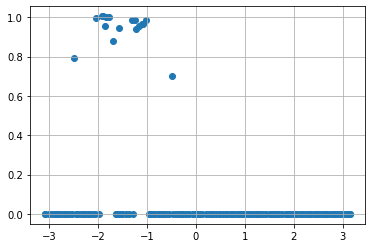

In [93]:
plt.scatter(theta_k_is_30, w0_k_is_30)
plt.grid(True)

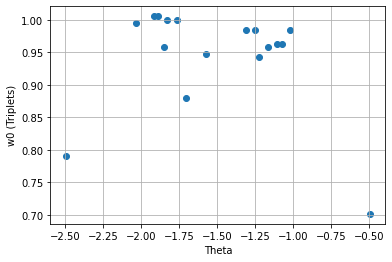

In [94]:
plt.scatter(theta_k_is_30[inds_where_w0_nonzero], w0_k_is_30[inds_where_w0_nonzero])

plt.xlabel("Theta")
plt.ylabel("w0 (Triplets)")
plt.grid(True)

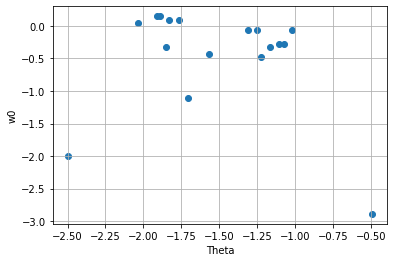

In [95]:
plt.scatter(theta_k_is_30[inds_where_w0_nonzero], ( w0_k_is_30[inds_where_w0_nonzero] - np.sqrt(9.81*k_slice) )  / k_slice )

plt.xlabel("Theta")
plt.ylabel("w0")
plt.grid(True)

In [96]:
x1 = theta_k_is_30[inds_where_w0_nonzero]
y = ( w0_k_is_30[inds_where_w0_nonzero] - np.sqrt(9.81*k_slice) )  / k_slice

In [97]:
def sinusoidinal(x, a, b):
    return a*np.cos(x - b) 

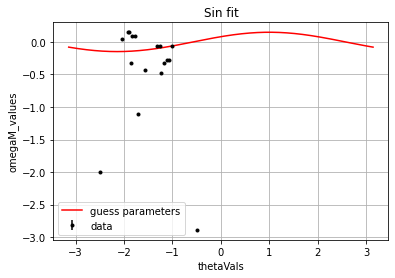

In [98]:
# plot the raw data
plt.errorbar(x1, y, yerr=0, fmt=".", color = 'black', label = 'data')
plt.grid(True)
plt.xlabel('thetaVals')
plt.ylabel('omegaM_values')


# initial guess
pars0 = ( max(y), 1)

# overlay exponential 

x = np.linspace(-np.pi, np.pi, 1000)

plt.plot(x, sinusoidinal(x,*pars0), color = 'red', label = 'guess parameters')

plt.legend();
plt.title("Sin fit");

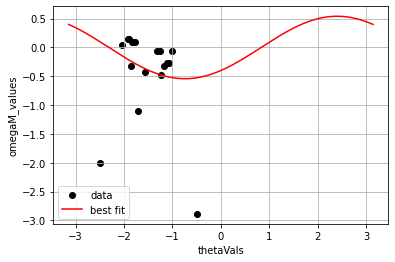

In [99]:
popt, pcov = curve_fit(sinusoidinal, x1, y, absolute_sigma=True, p0=pars0)

# extract best-fit parameter and its error
a_opt = popt[0]
a_opt_err = np.sqrt(pcov[0, 0])

# extract best-fit parameter and its error
b_opt = popt[1]
ab_opt_err = np.sqrt(pcov[1, 1])


# plot data
plt.scatter(x1, y, color = 'black', label = 'data')

# creating x interval to include in y fit
x = np.linspace(-np.pi, np.pi, 1000)
y_fit = sinusoidinal(x, *popt)
plt.plot(x, y_fit, color="red", label="best fit")

plt.grid(True)
plt.xlabel('thetaVals')
plt.ylabel('omegaM_values')
#plt.ylim(1.65, 2.08)
plt.legend();

In [100]:
a_opt

0.5419042728061151

In [101]:
np.pi - b_opt

0.7411683857001132

### Grubbs Test to remove outliers

In [102]:
def grubbs_test(x, y):
    """
    Grubb's test removes outlier in y axis and also removes the corresponding x value
    """

    # Gets mean and standard deviation of data
    mean_data = np.mean(y)
    std_data = np.std(y)

    # Calculate Grubbs test statistic
    z_scores = np.abs((y - mean_data) / std_data)
    max_z = np.max(z_scores)

    # Calculate critical value based on the t-distribution
    n = len(y)
    critical_value = t.ppf(0.975, n - 2) / np.sqrt(n)

    # Identify and removes any outlier
    outlier_index = np.argmax(z_scores)
    if max_z > critical_value:
        #print(f"Outlier detected at index {outlier_index}, value: {y[outlier_index]}")
        y = np.delete(y, outlier_index)
        x = np.delete(x, outlier_index)

        
    return x, y 

In [103]:
x1, y = grubbs_test(x1, y)

In [104]:
y

array([-1.9982029 ,  0.04383232,  0.14855208,  0.14855208,  0.0961922 ,
       -0.32268682,  0.0961922 , -1.10808498, -0.42740657, -0.06088743,
       -0.06088743, -0.47976645, -0.32268682, -0.27032694, -0.27032694,
       -0.06088743])

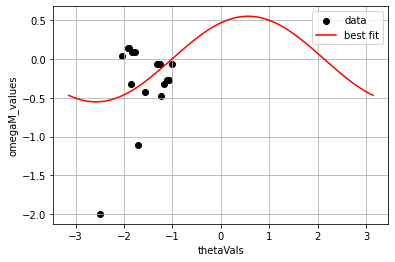

In [105]:
popt, pcov = curve_fit(sinusoidinal, x1, y, absolute_sigma=True, p0=pars0)

# extract best-fit parameter and its error
a_opt = popt[0]
a_opt_err = np.sqrt(pcov[0, 0])

# extract best-fit parameter and its error
b_opt = popt[1]
ab_opt_err = np.sqrt(pcov[1, 1])


# plot data
plt.scatter(x1, y, color = 'black', label = 'data')

# creating x interval to include in y fit
x = np.linspace(-np.pi, np.pi, 1000)
y_fit = sinusoidinal(x, *popt)
plt.plot(x, y_fit, color="red", label="best fit")

plt.grid(True)
plt.xlabel('thetaVals')
plt.ylabel('omegaM_values')
#plt.ylim(1.65, 2.08)
plt.legend();

In [106]:
a_opt

0.5522989397625419

In [107]:
b_opt

0.5606511048695069

## 2.4.2 Loop for many k values

In [108]:
def sinusoidinal(x, a, b):
    return a*np.cos(x - b) 

In [109]:
cut_k_array = np.arange(0.001, 0.35, 0.001)

U_array = []
Φ_array = []

for i in range(len(cut_k_array)):
    k_slice = cut_k_array[i]

    ind = np.where(np.round(K_2D, 2) == k_slice)
    
    # Slice at wavenumber cut_k - once k is within 0.01 it is counted as a slice
    w0_is_k = w0_2D[ind[0], ind[1]]
    theta_is_k = theta_2D[ind[0], ind[1]]
    
    # w and theta values along k_slice
    inds_where_w0_nonzero = np.where(w0_is_k != 0)
    
    if len(inds_where_w0_nonzero[0]) > 1:
        # How many nonzero w0 theres needs to be to be counted (increased numbers, increases accuracy)
        nonzero_theta_at_k = theta_is_k[inds_where_w0_nonzero]
        nonzero_w0_at_k = w0_is_k[inds_where_w0_nonzero]
        
        x_theta = nonzero_theta_at_k
        y_theta = (nonzero_w0_at_k - np.sqrt(9.81 * k_slice)) / k_slice
        
        # Preform Grubbs test to remove outliers
        x_theta, y_theta = grubbs_test(x_theta, y_theta)
        
        # Fitting Cos onto points
        pars0 = (max(y_theta), 1)  # initial guess
        popt, pcov = curve_fit(sinusoidinal, x_theta, y_theta, absolute_sigma=True, p0=pars0)
        
        # U value
        U_opt = popt[0]
        U_opt_err = np.sqrt(pcov[0, 0])
        U_array.append(np.abs(U_opt))
        
        # Φ
        Φ_opt = popt[1]
        Φ_opt_err = np.sqrt(pcov[1, 1])
        
        if U_opt > 0:
            Φ_opt = np.pi - Φ_opt
        # Condition due to definition of direction of current 
        
        Φ_array.append(Φ_opt)
    else:
        # If no values in inds_where_w0_nonzero, append None or a placeholder value as needed
        U_array.append(None)
        Φ_array.append(None)


(0.0, 1.0)

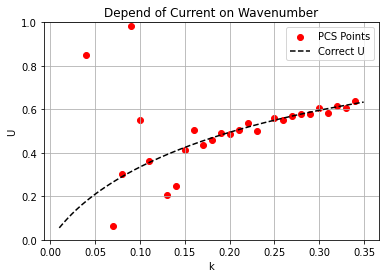

In [206]:
plt.scatter(cut_k_array, U_array, color = 'red', label = 'PCS Points')
plt.plot(k, Uk[:,0], color = 'black', linestyle = '--',  label='Correct U')

plt.xlabel("k")
plt.ylabel("U")
plt.title("Depend of Current on Wavenumber")
plt.grid(True)
plt.legend()
plt.ylim(0, 1)

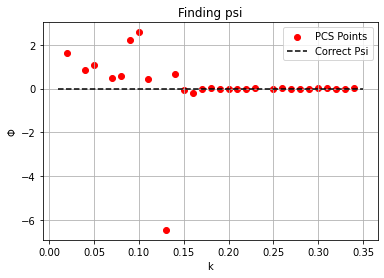

In [111]:
psi = 0

plt.scatter(cut_k_array, Φ_array, color = 'red', label = 'PCS Points')
plt.plot(k, np.linspace(psi, psi,len(k)), color = 'black', linestyle = '--', label='Correct Psi')

plt.xlabel("k")
plt.ylabel("Φ")

plt.title("Finding psi")
plt.grid(True)
plt.legend()

# 2.5 Ideas about (0,0)

In [112]:
# Using a loop
result_array = []
for value in Φ_array:
    if value is not None:
        result_array.append(value)

# Using list comprehension
psi_array = [value for value in Φ_array if value is not None]

print(len(psi_array))

29


In [113]:
# Using a loop
result_array = []
for value in U_array:
    if value is not None:
        result_array.append(value)

# Using list comprehension
result_array = [value for value in U_array if value is not None]

print(len(result_array))

29


In [114]:
# Using list comprehension with enumerate
non_none_indices = [index for index, value in enumerate(U_array) if value is not None]

In [115]:
cut_k_array[non_none_indices]

array([0.02, 0.04, 0.05, 0.07, 0.08, 0.09, 0.1 , 0.11, 0.13, 0.14, 0.15,
       0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22, 0.23, 0.25, 0.26, 0.27,
       0.28, 0.29, 0.3 , 0.31, 0.32, 0.33, 0.34])

In [116]:
x2 = cut_k_array[non_none_indices][0:]
y2 = result_array[0:]

In [117]:
x

array([-3.14159265, -3.13530318, -3.1290137 , -3.12272423, -3.11643475,
       -3.11014528, -3.1038558 , -3.09756633, -3.09127686, -3.08498738,
       -3.07869791, -3.07240843, -3.06611896, -3.05982948, -3.05354001,
       -3.04725053, -3.04096106, -3.03467158, -3.02838211, -3.02209263,
       -3.01580316, -3.00951368, -3.00322421, -2.99693473, -2.99064526,
       -2.98435578, -2.97806631, -2.97177683, -2.96548736, -2.95919788,
       -2.95290841, -2.94661894, -2.94032946, -2.93403999, -2.92775051,
       -2.92146104, -2.91517156, -2.90888209, -2.90259261, -2.89630314,
       -2.89001366, -2.88372419, -2.87743471, -2.87114524, -2.86485576,
       -2.85856629, -2.85227681, -2.84598734, -2.83969786, -2.83340839,
       -2.82711891, -2.82082944, -2.81453996, -2.80825049, -2.80196102,
       -2.79567154, -2.78938207, -2.78309259, -2.77680312, -2.77051364,
       -2.76422417, -2.75793469, -2.75164522, -2.74535574, -2.73906627,
       -2.73277679, -2.72648732, -2.72019784, -2.71390837, -2.70

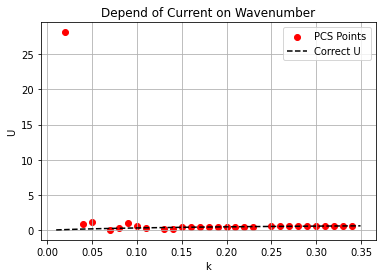

In [118]:
plt.scatter(x2, y2, color = 'red', label = 'PCS Points')
plt.plot(k, Uk[:,0], color = 'black', linestyle = '--',  label='Correct U')

plt.xlabel("k")
plt.ylabel("U")
plt.title("Depend of Current on Wavenumber")
plt.grid(True)
plt.legend()
#plt.ylim(0, 1)

In [119]:
def power(x, a, b, c):
    return a*x**b + c

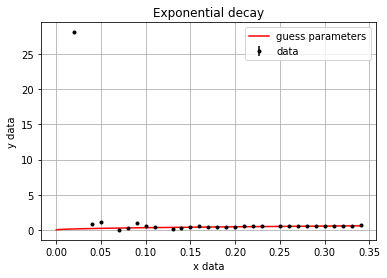

In [120]:
# plot the raw data
plt.errorbar(x2, y2, yerr=0, fmt=".", color = 'black', label = 'data')
plt.grid(True)
plt.xlabel('x data')
plt.ylabel('y data')


# initial guess
pars0 = (1, 1/2, 0.01)

# overlay exponential 

x = np.linspace(0, max(x2), 1000)

plt.plot(x, power(x,*pars0), color = 'red', label = 'guess parameters')

plt.legend();
plt.title("Exponential decay");

In [121]:
# perform fitting

popt, pcov = curve_fit(power, x2, y2, absolute_sigma=True, p0=pars0)

# plot data
plt.errorbar(x2, y2, yerr=0, fmt=".", color = 'black', label = 'data')

# creating x interval to include in y fit
x = np.linspace(0, max(x2), 1000)
y_fit = power(x, *popt)
plt.plot(x, y_fit, color="red", label="best fit")


plt.grid(True)
plt.xlabel("x data")
plt.ylabel("y data")
plt.legend()

plt.ylim(0,1)

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

In [ ]:
len(psi_array)

In [ ]:
plt.scatter(x2, y2*np.cos(psi_array), color = 'red', label = 'Ux Points')
plt.scatter(x2, y2*np.sin(psi_array), color = 'green', label = 'Uy Points')
plt.plot(k, Uk[:,0], color = 'black', linestyle = '--',  label='Correct Ux')

plt.xlabel("k")
plt.ylabel("U")
plt.title("Depend of Current on Wavenumber")
plt.grid(True)
plt.legend()
plt.ylim(-1, 1)